SIR Model Code for SIRI (June 5 - July 28, 2023)
- SIR Model as a class
- Functions for plotting SIR timeseries and surface plots
- Functions for reading and writing csv files
- Plotting for global mins by themselves (no surface plots)
- Testing conservation law from Baike paper
- Recreated plots from Sontag paper

Future work: 
1. Generalize SIR Model
2. Alter how betas are initialized (make 2D)
3. Optimize 
4. Clean up data files

In [1]:
# Class: SIR Model for two populations
import numpy as np

class SIR:
    def __init__(self, beta, Ns):
        self.beta = beta
        self.Ns = Ns
                
    def flow(self, s, x, p, index):
        return p * s[index] * (self.beta[index * 2] * x[0] + self.beta[index * 2 + 1] * x[1]) / self.Ns[index]
    
    def s_dot(self, s, x, p, index):        # Susceptible rate
        return -self.flow(s, x, p, index)
        
    def x_dot(self, s, x, gamma, p, index): # Infection rate
        return self.flow(s, x, p, index) - gamma[index] * x[index]

    def r_dot(self, x, gamma, index):       # Recovery rate
        return gamma[index] * x[index]
        
    def step(self, h, s, x, r, gamma, p, index): # Use Euler's Method to calculate each step
        s_now, x_now, r_now = s[index], x[index], r[index]
        s_next = s_now + h*self.s_dot(s, x, p, index)
        x_next = x_now + h*self.x_dot(s, x, gamma, p, index)
        r_next = r_now + h*self.r_dot(x, gamma, index)
        return s_next, x_next, r_next
        
    def simulate(self, inits, lockdown,res):
        h, s0, x0, r0, gamma, p, numsteps = inits
        ss, xs, rs = np.empty([int(numsteps/res), len(s0)]), np.empty([int(numsteps/res), len(x0)]), np.empty([int(numsteps/res), len(r0)]) # divide numsteps by some number to get correct total index
        ss[0], xs[0], rs[0] = s0, x0, r0 # Keep track of all s, x, r for the populations over all days

        for k in range(int(numsteps/res)-1): # Implement time-varying p value for lockdown
            #index = int(k / res)
            s, x, r = ss[k], xs[k], rs[k] #[index]
            temps, tempx, tempr = [], [], [] # Temporarily holds values calculated in lockdown loop
            
            # For each population, use their specified lockdown start time
            for l in range(len(lockdown[0])):    
                # Change p values depending on lockdown status of the population
                if k >= lockdown[0][l] and k <= (lockdown[0][l] + lockdown[1][l]): # /res
                    pops, popx, popr = self.step(h*res, s, x, r, gamma, p, l)              
                else:
                    pops, popx, popr = self.step(h*res, s, x, r, gamma, 1, l)
                
                temps.append(pops) 
                tempx.append(popx)
                tempr.append(popr)
            ss[k+1], xs[k+1], rs[k+1] = temps, tempx, tempr
        return ss, xs, rs

In [1]:
## IN PROGRESS - Class: Generalized SIR Model with matrices
import numpy as np

class SIR_gen:
    def __init__(self, beta, Ns):
        self.beta = beta
        self.Ns = Ns
                
    def flow(self, s, x, p): 
        I, X, B, P = np.identity(len(x)), np.diag(x.flatten()), np.reshape(self.beta,[2,2]), np.diag(p)
        return np.divide(P @ s @ ((I-X) @ B @ x),self.Ns) # Is this getting the correct value? Is s supposed to be included??
    
    def s_dot(self, s, x, p): # Susceptible rate
        return -self.flow(s, x, p)
        
    def x_dot(self, s, x, gamma, p): # Infection rate
        return self.flow(s, x, p) - gamma @ x

    def r_dot(self, x, gamma): # Recovery rate
        return gamma @ x
        
    def step(self, h, s, x, r, gamma, p): # Use Euler's Method to calculate each step
        s_now, x_now, r_now = s, x, r
        s_next = s_now + h*self.s_dot(s, x, p)
        x_next = x_now + h*self.x_dot(s, x, gamma, p)
        r_next = r_now + h*self.r_dot(x, gamma)
        return s_next, x_next, r_next
        
    def simulate(self, h, s0, x0, r0, gamma, p, numsteps, lockdown):
        s, x, r = s0, x0, r0
        ss, xs, rs = np.empty([numsteps, len(s)]), np.empty([numsteps, len(x)]), np.empty([numsteps, len(r)])
        ss[0], xs[0], rs[0] = s, x, r
        step_p = p

        for k in range(numsteps): # Implement time-varying p value for lockdown
            # For each population, use their specified lockdown start time
            for l in range(len(lockdown[0])):
                if k < lockdown[0][l] or k > (lockdown[0][l] + lockdown[1][l]):
                    step_p[l] = 1 # If the population is not in lockdown, use 1 for the p value
                    
            s, x, r = self.step(h, s, x, r, gamma, step_p)
            ss, xs, rs = [s], [x], [r]
        return ss, xs, rs

In [2]:
## Run this code block for all the intermediate functions
# 6/26/23: Rewrote code into an intersect_plot function with plotting
def intersect_plot(X,Y,pops,res,start): # Currently intersection_line is calculated but not plotted (see line 37 to plot line)         
    import plotly.graph_objects as go
    import numpy as np

    # Approximate intersection with average infection peak
    diff          = abs(pops[0] - pops[1])                   # Calculate the difference between each infection peak of both populations
    mindices      = np.argmin(diff, axis=1)                  # Find indices of min of each row
    yrange        = np.arange(len(mindices))                 # Create y-values based on the number of mindices
    avg_maxes     = (pops[0] + pops[1]) / 2                  # Calculate the average infection peak of the two populations for each iteration
    intersections = avg_maxes[mindices,yrange]               # Find the minimum infection peaks using the averages
    intersectx    = np.array(mindices*res) + start[0]        # Adjust the mindices by the resolution and start time range
    intersecty    = np.array(yrange*res) + start[1]          # Adjust yrange by the resolution and start time range   

    # Create plot objects
    surface1          = go.Surface(x=X,y=Y,z=pops[0],colorscale='Peach',showscale=True, name='Population 1', colorbar=dict(x=0.015,xref="container",title='Population 1')) # Viridis
    surface2          = go.Surface(x=X,y=Y,z=pops[1],colorscale='RdPu',showscale=True, name='Population 2',colorbar=dict(x=0.7,xref="container",title='Population 2')) # Magma
    intersection_line = go.Scatter3d(x=intersectx,y=intersecty,z=intersections,mode='markers', marker=dict(color='pink'),name='Intersection')
   
    # Create the layout
    layout = go.Layout(scene=dict(
        xaxis = dict(title='t<sub>s<sub>1</sub></sub> (Days)'),
        yaxis = dict(title='t<sub>s<sub>2</sub></sub> (Days)'),
        zaxis = dict(title='Max I'),#,range=[-0,1]),
        aspectmode ='cube'
    ),
        title = 'Max Infection Peaks for Two Populations Staggering Lockdown Start Times (t<sub>s</sub>)',
        autosize=False,
        width=900,
        height=500,
        margin=dict(l=20, r=20, t=50, b=20),
        showlegend=False        
    )

    # Create figure and show
    fig = go.Figure(data=[surface1, surface2],layout=layout) #, intersection_line
    fig.show()
    #fig.write_html("plot.html", auto_open=True) # Alternative to fig.show() if it's not working correctly

    return intersections, mindices

# 6/26/23: Find minimum of intersection line and display info
def mintersect(intersections, mindices, res, start):
    import numpy as np
    # Calculate the minimum infection peak out of the intersections
    min = np.min(intersections)
    ts2 = np.where(min == intersections)
    ts2_index = ts2[0]

    # Display info
    print(min, ts2_index*res+start[1])
    print("args", mindices[ts2_index]*res+start[0])
    print("To reach minimum max infection, ts for population 1 = ", mindices[ts2_index]*res+start[0], ", ts for population 2 = ", ts2_index*res+start[1], ", and average max infection = ", min)

    return [min, mindices[ts2_index]*res+start[0], ts2_index*res+start[1]]

# 6/26/23: Plot just the intersection line using args, the range of lockdown ts, and a/Ns
def plot_line(x, y, z):
    import plotly.graph_objects as go

    # Create the layout
    layout = go.Layout(scene=dict(
        xaxis = dict(title='t<sub>s1</sub> (Days)'),
        yaxis = dict(title='t<sub>s2</sub> (Days)'),
        zaxis = dict(title='Max I'),
        aspectmode = 'cube'
    ),
        title = 'Max Infection Peaks for Two Populations Staggering Lockdown Start Times (t<sub>s</sub>)'
    )

    # Create the line object as a scatter plot
    line = go.Scatter3d(x=x,y=y,z=z, mode='markers')
    # Create figure and show
    fig = go.Figure(data=[line],layout=layout)
    fig.show()

# Take input variables and write into separate csv files
def write(pops, inits):
    import time
    import pandas as pd

    # Create a new file name based on the time stamp
    timestamp = time.strftime("%m%d %H%M%S")
    datafile  = f"DataFiles/{timestamp} data.csv"
    initfile  = f"DataFiles/{timestamp} init.csv"

    # If the input pops is 3D, flatten it to 2D
    array = np.reshape(pops,[len(pops), -1])

    # Create population headers corresponding to populations in array
    pop_headers = []
    for a in range(len(array)):
        pop_headers.append(f"pop{a+1}")
        
    # Create two Data Frames for population data and initialization
    dataf = pd.DataFrame(array,index=pop_headers)
    initf = pd.DataFrame(inits, index=['h','s0','x0','r0','gammas','p','numsteps','beta','Ns','tsrange','lockdownlen','resolution'])

    # Save the DataFrames to CSV files
    dataf.to_csv(datafile,header=False,float_format='%.8f')
    initf.to_csv(initfile,header=False,float_format='%.8f')#,sep=",")

# Read an input csv file and return a DataFrame
def read(filename):
    import pandas as pd

    # Read data from CSV file
    return pd.read_csv(filename,header=None,index_col=[0])

# IN PROGRESS: Read the inits file and convert strings to floats or arrays as appropriate
def process_inits(filename):
    import ast
    inits = read(filename)
    return inits
    #for i in inits.index:
        #print(ast.literal_eval(inits.T[i].iloc[0].replace(' ',',')))

# 7/6/23: Read csv files to plot function
def show(datafile, initfile):
    import numpy as np
    import ast
    # Read the two input files
    data    = read(datafile).values.tolist()
    inits   = process_inits(initfile)
    res     = float(inits.loc["resolution"].iloc[0])
    tsrange = np.array(ast.literal_eval(inits.loc["tsrange"].iloc[0].replace(" ",",")))
    if tsrange.ndim == 1: ts = np.array([[0,0],tsrange])

    # Plot data
    length = int(np.sqrt(len(data[0])))
    pops   = np.reshape(data,[2,length,length])
    X,Y    = np.meshgrid(np.arange(ts[0][0],ts[1][0],res),np.arange(ts[0][1],ts[1][1],res)) 
    return [intersect_plot(X,Y,pops,res,ts[0]), pops, res, ts]

# Find the global minimum of every population
def globalmin(pops):
    import numpy as np
    mins = []
    for p in pops:
        ts  = []
        # Get the index of the minimum
        min = np.min(p)
        tsindex  = np.where(min == p)
        #print("indexes", ts1[0],ts2[0])
        #print("min",p[ts1[0]][ts2[0]])
        for t in range(len(tsindex)): ts.append(tsindex[t][0])
        print("\nMinimum of the population is", min, "at", ts)
        mins.append([min, ts])
    return mins

import csv
# Add data to an existing csv file
def add_data(filename, data):
    # Calculate the intersections and global mins
    intersect_min = mintersect(data[0][0], data[0][1])
    globalmins = globalmin(data[1])
    all_mins = [filename] + [intersect_min] + globalmins

    # Open the CSV file in "append" mode
    with open('data_comp.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write the data as a new row
        writer.writerow(all_mins)

# Plot the average of max infections in a surface plot
def avgplot(pops, res, ts):
    import numpy as np
    import plotly.graph_objects as go
    import math 

    newcolor = ['#fddfb1', '#fab88e','#f4957d','#ec7771','#e75f6a','#d44863','#b43458']
    # Set up the surface and find the minimum
    if pops.ndim > 1: avg = (pops.sum(axis=0)) / len(pops)
    else: 
        length = int(math.sqrt(len(pops))) 
        avg = np.reshape(pops,[length,length])

    # Set up the surface plot
    X,Y = np.meshgrid(np.arange(ts[0][0],ts[1][0],res),np.arange(ts[0][1],ts[1][1],res))
    surface = go.Surface(x=X,y=Y,z=avg,colorscale=newcolor,showscale=False) # Magma
    # Set up the minimum plot
    min = np.min(avg)
    y,x = np.where(avg == min)
    globmin = go.Scatter3d(x=x*res+ts[0][0],y=y*res+ts[0][1],z=[min],mode='markers',marker=dict(color='purple'))
    
    # Create the layout
    layout = go.Layout(scene=dict(
        xaxis = dict(title='t<sub>s<sub>1</sub></sub> (Days)'),
        yaxis = dict(title='t<sub>s<sub>2</sub></sub> (Days)'),
        zaxis = dict(title='Max I'),
        aspectmode ='cube'
    ),
        title = 'Average Max Infection Peaks between Two Populations Staggering Lockdown Start Times (t<sub>s</sub>)'
    )

    # Create figure and show
    fig = go.Figure(data=[surface,globmin],layout=layout)
        
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        margin=dict(l=20, r=20, t=50, b=20)
    )
    fig.show()

    return x,y,min

# Find the maximum of the average infections of a network - currently, r is commented out, but it could be re-included
def averages(sir, res, Ns):
    s, x = sir #r
    # Calculate the average population, average infections, and max of infections
    pops  = x.T
    Nsavg = (Ns.sum(axis=0)) / len(Ns)
    savg  = ((s.T.sum(axis=0)) / len(s.T)) / Nsavg
    xavg  = ((pops.sum(axis=0)) / len(pops)) / Nsavg
    #ravg = ((r.T.sum(axis=0)) / len(r.T)) / Nsavg
    max   = np.max(xavg)

    # Plot steps vs xavg (keep between 0 and 1)
    steps = np.arange(0,len(pops[0])*res,res)
    plt.plot(steps,savg,color='xkcd:magenta',label='Average Susceptible')
    plt.plot(steps,xavg,color='red',label='Average Infectious')
    #plt.plot(steps,ravg,color='orange',label='Average Recovered')
    plt.plot([0,len(steps)*res],[max,max], label='Max Infection',color='xkcd:rose pink',linestyle="dashdot")

    # Add plot details
    plt.xlabel('Days')
    plt.ylabel('Proportion')
    plt.title('Average Infection of a Network')
    plt.legend()
    plt.ylim([0,1])

    return max

0.52002069 [74.]
args [69.]
To reach minimum max infection, ts for population 1 =  [69.] , ts for population 2 =  [74.] , and average max infection =  0.52002069


0.5116078504804883


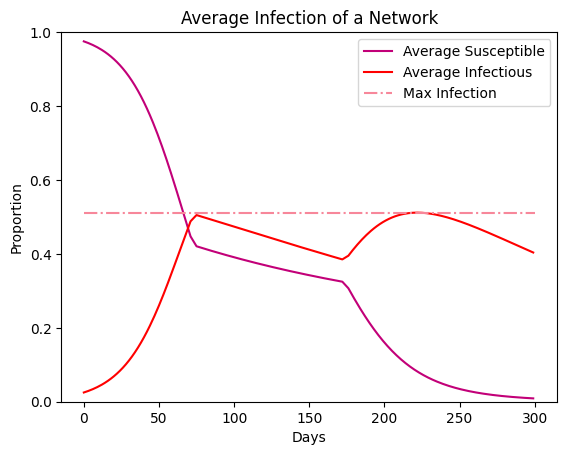

In [50]:
## ============= # Run intermediate functions above =============================================================== ##
## ================================================================================================================ ##

# Test show function - works
# all_data is in the form: [[intersections, mindices], pops, res, ts]
all_data = show('DataFiles/0706 130022 data.csv' ,'DataFiles/0706 130022 init.csv')
mintersect(all_data[0][0],all_data[0][1],all_data[2],all_data[3][0])

# Test avgplot function
sir_object = SIR(inits[7], inits[8])
x,y,min = avgplot(all_data[1],all_data[2],all_data[3])
lockdown   = [np.array([x,y]), inits[10]/inits[11]] 
ss, xs, rs = sir_object.simulate(inits[0:7],lockdown,inits[11])

# Test averages function using global inits
print(averages([ss, xs],inits[11],inits[8]))

# Test mintersect and globalmin functions
#intersect_min = mintersect(all_data[0][0], all_data[0][1],all_data[2],all_data[3][0])
#globalmins = globalmin(all_data[1])
#data = [intersect_min] + globalmins

# Add data to file using daytime string
#add_data('0710 173617',all_data)

# Make a Windows sound to alert programmer that the code is done running
import winsound
winsound.PlaySound("*", winsound.SND_ASYNC)

In [ ]:
# 7/9/23: Comparison of Global Mins Graph: currently can plot up to 4 subplots
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ast

df = pd.read_csv('data_comp.csv')
rowcnt = round(len(df)/2)
fig = make_subplots(rows=2, cols=2,specs=[[{'type': 'scatter3d'}]*2]*2) #rows=rowcnt and specs has *7) - change rows=# and cols=# if plotting more than 4 subplots
colors = ['red', 'green', 'blue']

# Break down each row of the csv file into plottable elements (x,y,z)
def interpret(row):
    # Evaluate specific data
    mintersect = ast.literal_eval(row.loc['Intersection Min'])
    minpop1 = ast.literal_eval(row.loc['Pop 1 Min'])
    minpop2 = ast.literal_eval(row.loc['Pop 2 Min'])

    # Set up z, x, y (in that order!)
    z = [mintersect[0], minpop1[0], minpop2[0]]
    x = [mintersect[1], minpop1[1], minpop2[1]]
    y = [mintersect[2], minpop1[2], minpop2[2]]
    
    return x,y,z

# For each file row, create a scatter plot with the three min points
colcnt = 1
indexes = range(22,23) # Update the indexes to include the data files you want to plot - currently, only handles up to 4
for i in df.index[indexes]:
    # Set up subplot from csv file 
    x,y,z = interpret(df.loc[i])
    tempfig = go.Scatter3d(x=x, y=y, z=z, mode='markers',marker=dict(color=colors),name=df.loc[i,'File Name'])
    scene = "scene{}".format(i + colcnt * 7)
    
    if i / 23 >= 1: colcnt = 2 # if i / rowcnt >= 1: colcnt = 2 -- Update the i / # to accomodate indexes from above
    fig.add_trace(tempfig, row=1, col=colcnt) # row=((i % rowcnt)+1)

    # Add axes
    fig.update_scenes(xaxis_title="Pop 1 ts", yaxis_title="Pop 2 ts", zaxis_title="Max I", row=1, col=colcnt) # row=((i % rowcnt)+1)

# Create separate dummy traces for each color
legend_traces = []
labels = ['Intersection', 'Pop 1', 'Pop 2']
for c in range(len(colors)):
    dummy_trace = go.Scatter3d(x=[None], y=[None], z=[None], mode='markers', marker=dict(color=colors[c]),
                              showlegend=True, legendgroup='colors', name=labels[c])
    legend_traces.append(dummy_trace)

# Add the dummy traces to the figure
for trace in legend_traces:
    fig.add_trace(trace, row=1, col=1)

# Hide unwanted traces from the legend
for trace in fig.data:
    if trace.legendgroup != 'colors':
        trace.update(showlegend=False)

# Update subplot layout
fig.update_layout(height=800, width=1000, margin=dict(l=50, r=20, t=100, b=30),
                  title_text="Comparison of Global Mins")
# Display the figure
fig.show()

In [9]:
# Functions to run a new simulation and plot it

# Run a simulation with staggered lockdowns. tsrange is an array of the lockdown start time (ts) range for the populations and inits is the array of initial conditions 
def stagger_lockdown(tsrange, inits):
    # Initial variables
    all_maxes, min, maxvg, minpeaks = [], 100, [], [100]
    sir_object = SIR(inits[7], inits[8]) # Create the SIR Model object

    # Make a grid of all possible lockdown combinations
    X, Y = np.meshgrid(np.arange(tsrange[0][0],tsrange[1][0],inits[11]), np.arange(tsrange[0][1],tsrange[1][1],inits[11]))
    for i1 in range(len(X)):        # i1 represents the x value
        for i2 in range(len(Y)):    # i2 represents the y value
            # Vary the start time of lockdown; the second number is the length of the lockdown 
            lockdown   = [np.array([X[i1,i2],Y[i1,i2]])/inits[11], inits[10]/inits[11]] 
            ss, xs, rs = sir_object.simulate(inits[0:7],lockdown,inits[11])
            num        = len(xs[0])

            # Find the maximum peak of infections for each population, store in maxes
            maxes = []
            for j in range(num):
                rowx = [row[j] for row in xs]
                max  = np.max(rowx)
                maxes.append(max)

            # Store all of the maxes for every population in all_maxes
            if i1 == 0 and i2 == 0:
                all_maxes = maxes
            else:
                all_maxes = np.c_[all_maxes, maxes] # Appended as columns so there is one population per row

            # If the iteration reduces the maximum the most, it becomes the minimum
            if np.max(maxes) <= min:
                min           = np.max(maxes) # switched from min to max
                peaklockdowns = lockdown[0] * inits[11]
                # Get all of max peaks from the two populations: find one max before lockdown ends and the other after lockdown lifts
                minpeaks = []
                for i in range(len(lockdown[0])):
                    minpeaks.append([np.max(xs.T[i][0:int(lockdown[0][i]+lockdown[1][i])]),np.max(xs.T[i][int(lockdown[0][i]+lockdown[1][i]):int(inits[6]/inits[11])])])
                mindata = [ss, rs, xs]

            # Calculate the max of the average of the infected proportions
            xavg = ((xs.sum(axis=1))) / len(xs.T)
            Nsavg = ((inits[8].sum())) / len(inits[8])
            maxvg = np.append(maxvg,np.max(xavg) / Nsavg) 

    # Define pops based on all_maxes
    pops = define_pops(all_maxes,inits[8]) 
    #write(pops,inits) # Uncomment to write data collected to a csv file

    # Plot the surfaces and intersection points, return additional data
    return [intersect_plot(X,Y,pops,inits[11],inits[9][0]), pops, inits[11], mindata, [maxvg, xavg / Nsavg], [minpeaks,peaklockdowns]]

# Plot a simulation with staggered lockdowns. ts is the start times for the populations and inits is the array of initial conditions 
# Returns infection data xs
def stagger_plot(inits, ts, ax): 
    # Run a sim based on inputs
    sir_object = SIR(inits[7], inits[8]) # Create the SIR Model object
    lockdown   = [np.array(ts)/inits[11], inits[10]/inits[11]]
    ss, xs, rs = sir_object.simulate(inits[0:7],lockdown,inits[11])
    ss, xs, rs = ss.T, xs.T, rs.T
    plt.figure(figsize=(15,12))

    # Add plot axes and title
    ax.set(xlabel='Days',ylabel='Proportion',title='Infected Proportions of Two Populations with Staggered Lockdown')

    # Make lines for ts and ts + T
    ts1line, ts2line, tsy = np.array([ts[0],ts[0]]), np.array([ts[1],ts[1]]), [0,1]
    ax.plot(ts1line,tsy,'-', label='$t_{s_1}$='+str(ts[0]), color='xkcd:rose pink',alpha=0.5)
    ax.plot(ts2line,tsy,'-', label='$t_{s_2}$='+str(ts[1]), color='xkcd:orange',alpha=0.5) # coral
    ax.add_patch(Rectangle((ts[0],0),inits[10][0],1,edgecolor='xkcd:rose pink',fill=False,hatch="\\",alpha=0.5))
    ax.add_patch(Rectangle((ts[1],0),inits[10][1],1,edgecolor='xkcd:orange',fill=False,hatch="/",alpha=0.5))
    
    x = np.arange(0,inits[6],inits[11])
    # Plot the three curves: susceptible is magenta, infected is red, and recovered is orange (matches poster/presentation colors)
    #ax.plot(x,ss[0]/inits[8][0],color='xkcd:magenta',label='Susceptible Pop. 1') # Susceptible
    #ax.plot(x,ss[1]/inits[8][1],color='xkcd:magenta',linestyle='dashed',label='Susceptible Pop. 2') # Susceptible
    ax.plot(x,xs[0]/inits[8][0],'r',label='Infected Pop. 1',linewidth=2.5) # Infected
    ax.plot(x,xs[1]/inits[8][1],'r',linestyle='dashed',label='Infected Pop. 2',linewidth=2.5) # Infected
    #ax.plot(x,rs[0]/inits[8][0],color='orange',label='Recovered Pop. 1') # Recovered 
    #ax.plot(x,rs[1]/inits[8][1],color='orange',linestyle='dashed',label='Recovered Pop. 2') # Recovered

    # Plot a line for both populations' maxes
    ax.plot([0,inits[6]],[np.max(xs[0]),np.max(xs[0])]/inits[8][0],label='Infection Peak of Pop. 1',linestyle='dashdot',color='xkcd:reddish pink')
    ax.plot([0,inits[6]],[np.max(xs[1]),np.max(xs[1])]/inits[8][1],label='Infection Peak of Pop. 2',linestyle='dashdot',color='xkcd:neon pink')

    # Plot a line for the actual max
    if np.max(xs[0]) > np.max(xs[1]): max = np.max(xs[0]) / inits[8][0]
    else: max = np.max(xs[1]) / inits[8][1]
    #ax.plot([0,inits[6]],[max,max],label='Network Max Infection',color='black',linestyle='dashdot')
    print("max:", np.max(xs[0]), np.max(xs[1]))

    # Add legend
    ax.legend(loc='upper right',prop={'size': 8})
    
    # Zoom in the scale (for poster/presentation)
    #ax.set_ylim([0.49,0.53])
    #ax.set_xlim([50,250])

    # Adjust figure size
    fig.set_figwidth(12)
    fig.set_figheight(8)

    # Save figure as png and display it inline
    #fig.savefig('Optimal SIR Lockdown, new - poster.png',dpi=500)
    fig.show()
    return xs

# Define a row in the pops array for each population's infection peaks (should be 3D array)
def define_pops(all_maxes,Ns):
    pops = []
    # Reshape each population's data based on the length of the whole array
    for i in range(len(all_maxes)):
        length = int(math.sqrt(len(all_maxes[i])))
        pops.append(np.reshape(all_maxes[i] / Ns[i],(length,length),order='F'))
    return pops

max: 60.711603752823635 60.87961440532056
peaks [[60.711603752823635, 57.20457502084823], [59.87452835737486, 60.87961440532056]]
3.507028731975403 1.0050860479457029


C:\Users\Sachi\AppData\Local\Temp\ipykernel_24792\3166706575.py:102: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



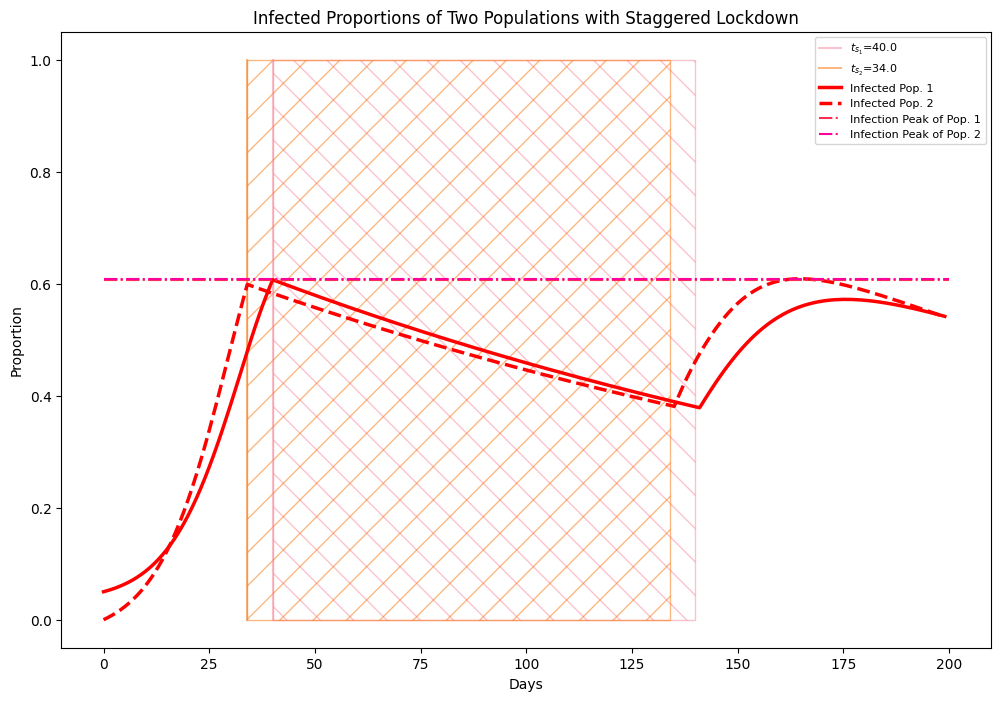

<Figure size 1500x1200 with 0 Axes>

In [8]:
# ============================================================================================================ #
    # Uncomment below for various functions
# ============================================================================================================ #
## Run this code block to create a new simulation
# 6/21/23 - works with fixed SIR class! Surface plot - main function as of 6/26/23
# Rewrite the nest loops for staggered lockdowns using a meshgrid 
import matplotlib.pyplot as plt
import math
import numpy as np 
from matplotlib.patches import Rectangle

# Implementation for two populations
beta       = np.array([0.5,0.5,0.75,0.75])  # Four transmission rates: between (beta[1] and beta[2]) and within (beta[0] and beta[3]) two populations
Ns         = np.array([100,100])          # Population size

# Initialize variables
h           = 0.1                               # Timestep
x0          = np.array([5,0])                   # Initial infected percentage of two populations
s0          = Ns - x0                           # Initial susceptible percentage of two pops
r0          = np.array([0,0])                   # Initial recovered percentage of two pops
gammas      = np.array([0.05,0.05])             # Rate of healing
p           = 0.01                               # Lockdown effect
numsteps    = 200                               # Number of days
tsrange     = np.array([[0,0],[100,100]])       # Range for start times of lockdowns  
lockdownlen = np.array([100,100])               # Length of each lockdown
resolution  = 1                                   # Gridding value

# Added beta, Ns, and lockdownlen for saving data, but only need inits[0:7] for calculation
inits = [h,s0,x0,r0,gammas,p,numsteps,beta,Ns,tsrange,lockdownlen,resolution]

# ====================================================================================================================================== #
# ====================================================================================================================================== #

## data holds [[intersections, mindices], pops, inits[11], [ss,xs], maxvg, [minpeaks,peaklockdowns]]
data = stagger_lockdown(tsrange,inits) 
#min_data = mintersect(data[0][0], data[0][1], data[2], tsrange[0]) # Gets average minimum peak
#avgplot(np.array(data[4]), resolution, tsrange)
#write(data[1],inits)

# ====================================================================================================================================== #

## Use to generate 4 plots using the SIR plot 
#fig, axs = plt.subplots(nrows=2,ncols=2)
#row, col = 0,0
#for ts1 in np.arange(40,40.4,0.1):
#    stagger_plot(inits, np.array([ts1,ts1]), axs[row,col])
#    col = col + 1
#    if col == 2:
#        row = 1
#        col = 0

# ====================================================================================================================================== #

# SIR Plot for Two Populations with input of lockdown time from the average
fig, axs = plt.subplots()
#print(data[5][1])
xs = stagger_plot(inits,data[5][1],axs)#[min_data[1][0],min_data[2][0]],axs) # [71,75]

# ====================================================================================================================================== #

# Show all 4 peaks of the network and calculate the difference between peaks for individual populations
minpeaks = []
lockdown   = [data[5][1]/inits[11], inits[10]/inits[11]] #np.array([71,75])
for i in range(len(lockdown[0])):
    minpeaks.append([np.max(xs[i][0:int(lockdown[0][i]+lockdown[1][i])]),np.max(xs[i][int(lockdown[0][i]+lockdown[1][i]):int(inits[6]/inits[11])])])
print("peaks", minpeaks)
print(abs(minpeaks[0][0]-minpeaks[0][1]),abs(minpeaks[1][0]-minpeaks[1][1]))

# ====================================================================================================================================== #

# Save the figure at a higher resolution
#fig.savefig('SIR for Avg Global Min.png',dpi=500)
#print(data[5]) # Resolution helps converge equal peaks

# ====================================================================================================================================== #

# SIR Plot and call the averages function
#fig, axs = plt.subplots()
#axs.plot(np.arange(0,inits[6]*inits[11],inits[11]),data[4][1])
#averages(data[3],inits[11],inits[8])

# ====================================================================================================================================== #

# Alert that code is done running
import winsound
winsound.PlaySound("*", winsound.SND_ASYNC)

In [ ]:
# Resolution test
inits[11] = 0.01
fig, axs = plt.subplots()
stagger_plot(inits, [69.8,74.3], axs)

# Tested same line of code above with different resolutions (increasing by 10 as you go down)
# 50.742082979739756 51.4287042273366
# 50.7132650855707 51.52547088047355
# 50.71039156462467 51.53512464943226
# 50.710104304176824 51.5360897967238

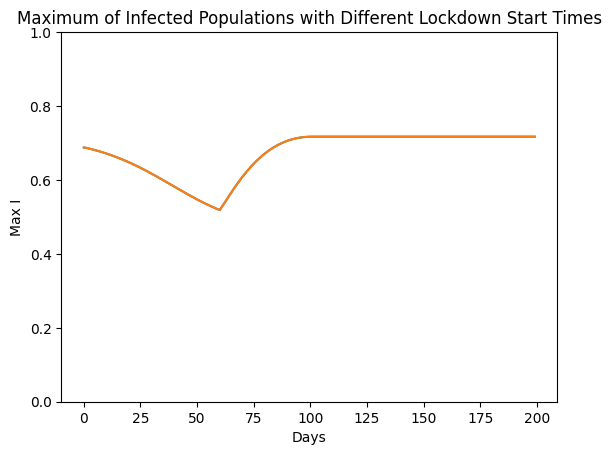

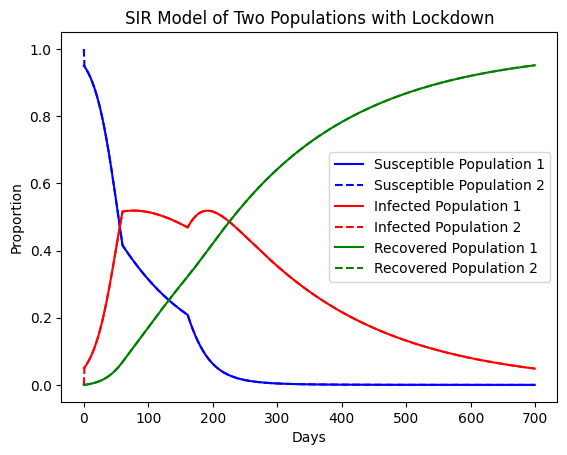

In [17]:
# For two populations, but uniform lockdowns
import matplotlib.pyplot as plt

# Implementation for two populations
beta = np.array([0.4, 0.2, 0.2, 0.4])   # Four transmission rates: between (beta[1] and beta[2]) and within (beta[0] and beta[3]) two populations
Ns = np.array([100,100])                # Population size
sir_object = SIR(beta, Ns)              # Create the SIR Model object

# Initialize variables
h = 0.1                         # Timestep
x0 = np.array([5,0])            # Initial infected percentage of two populations
s0 = Ns - x0                    # Initial susceptible percentage of two pops
r0 = np.array([0,0])            # Initial recovered percentage of two pops
gammas = np.array([0.05,0.05])  # Rate of healing
numsteps = 700                  # Number of days    
p = 0.2252                      # Lockdown effect
res = 1

# Run a simulation: range is each day that the lockdown sound start at, init = [h, x0, s0, r0, gammas, p], and numsteps is number of days
def sim_constlock(start_times, inits):
    all_maxes, maxes = [], []
    min = 100
    for i in start_times:
        # Vary the start time of lockdown; the second number is the length of the lockdown (currently always 100 days)
        lockdown = [[i], [100]]
        ss, xs, rs = sir_object.simulate(inits[0:7],lockdown,inits[7])
        num = len(xs[0])

        # Find the maximum peak of infections for each population, store in maxes
        maxes = []
        for j in range(num):
            rowx = [row[j] for row in xs]
            max = np.max(rowx) 
            maxes.append(max)
        # Store all of the maxes for every population in all_maxes
        all_maxes.append(maxes) 

        # If the iteration reduces the maximum the most, it becomes the minimum
        if np.min(maxes) <= min:
            min = np.min(maxes)
            mindata = [ss, xs, rs]
    return mindata, min, all_maxes

data, min, all_maxes = sim_constlock(range(200), [h, s0, x0, r0, gammas, p, numsteps, res])

# Create a figure to show iterations of lockdown start time including the found minimum value 
fig, ax = plt.subplots()
for i in range(len(Ns)):
    population = [row[i] for row in all_maxes]
    ax.plot(range(200), population / Ns[i])
#ax.plot(range(200), all_maxes / Ns, label='Population')
ax.set_ylim(0,1)
ax.set_xlabel('Days')
ax.set_ylabel('Max I')
ax.set_title('Maximum of Infected Populations with Different Lockdown Start Times')
plt.show()

# --------------------------------------------------------------------------------------- #
# Plot the three curves: susceptible is blue, infected is red, and recovered is green
fig, ax = plt.subplots()
ax.plot(range(numsteps),data[0][0:len(data[0]),0]/Ns[0],'b',label='Susceptible Population 1') # Susceptible
ax.plot(range(numsteps),data[0][0:len(data[0]),1]/Ns[1],'b', linestyle='dashed',label='Susceptible Population 2') # Susceptible
ax.plot(range(numsteps),data[1][0:len(data[1]),0]/Ns[0],'r',label='Infected Population 1') # Infected
ax.plot(range(numsteps),data[1][0:len(data[1]),1]/Ns[1],'r', linestyle='dashed',label='Infected Population 2') # Infected
ax.plot(range(numsteps),data[2][0:len(data[2]),0]/Ns[0],'g',label='Recovered Population 1') # Recovered 
ax.plot(range(numsteps),data[2][0:len(data[2]),1]/Ns[1],'g', linestyle='dashed',label='Recovered Population 2') # Recovered

# Add labels, title, and legend
ax.set_xlabel('Days')
ax.set_ylabel('Proportion')
ax.set_title('SIR Model of Two Populations with Lockdown')
ax.legend()
# Display the plot
plt.show()

In [ ]:
# Test conservation law for individual nodes of two population network
import math
import numpy as np
import matplotlib.pyplot as plt

# SIR implementation for two populations
beta        = np.array([0.5,0.5,0.5,0.5]) # Transmittion rate
Ns          = np.array([100, 100])        # Population size
sirs_object = SIR(beta, Ns)               # Create the SIR Model object

# Initialize variables
h           = 0.1                           # Timestep
x0          = np.array([5, 5])              # Initial infected percentage of population
s0          = Ns - x0                       # Initial susceptible percentage of pop
r0          = np.array([0, 0])              # Initial recovered percentage of pop
gammas      = np.array([0.05, 0.05])        # Rate of healing
numsteps    = 100                           # Number of steps
p           = 0.2252                        # Lockdown factor: affects rate of transmittion beta
tsrange     = np.array([[10,10],[11,11]])   # Range for start times of lockdowns  
lockdownlen = np.array([50,50])             # Length of each lockdown
res         = 0.01                          # Resolution
inits = [h,s0,x0,r0,gammas,p,numsteps]

# Conservation equation using the basic reproduction number for each population
def conservation_node(S,I,beta,gammas):
    repro = 0
    for b in beta:
        repro = repro + beta[b] / gammas
    return I + S - 1/repro * math.log(S) 

def conserve_calc_node(ss, xs, lockdown, res): # How to incorporate lockdown?
    beta = np.reshape(beta,[2,2])
    xaxis = np.arange(0,len(ss)*res,res)
    yaxis = []
    for i in range(len(ss)): # check that this len reflects number of pops
        for j in range(len(ss[i])):
            yaxis.append(conservation_node(ss[i][j],xs[i][j],beta[i],gammas[i]))
    return xaxis, yaxis

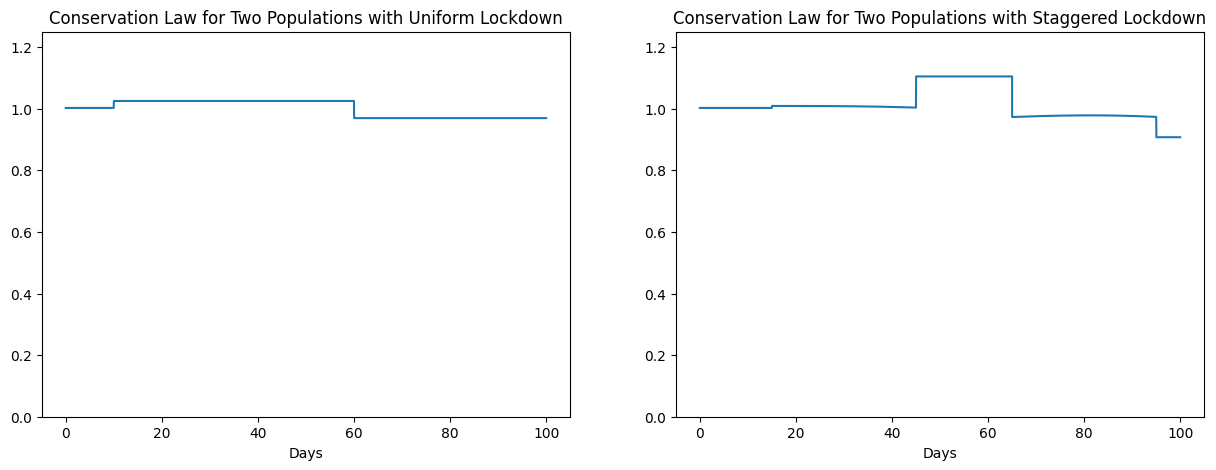

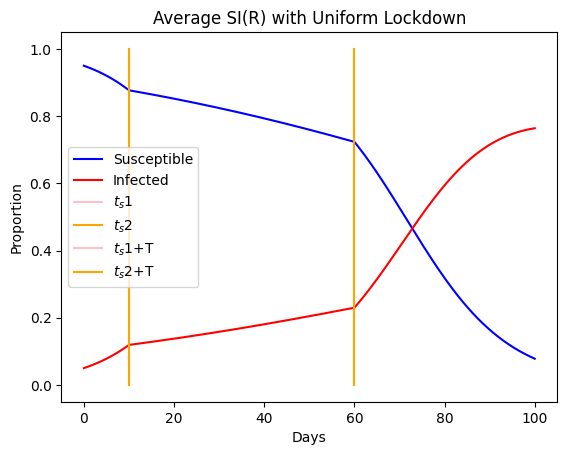

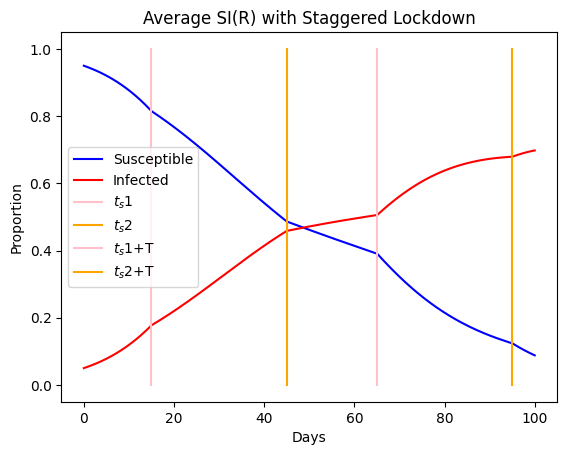

In [ ]:
# Test conservation law for two population network
import math
import numpy as np
import matplotlib.pyplot as plt

# SIR implementation for two populations
beta        = np.array([0.5,0.5,0.5,0.5]) # Transmittion rate
Ns          = np.array([100, 100])        # Population size
sirs_object = SIR(beta, Ns)               # Create the SIR Model object

# Initialize variables
h           = 0.1                           # Timestep
x0          = np.array([5, 5])              # Initial infected percentage of population
s0          = Ns - x0                       # Initial susceptible percentage of pop
r0          = np.array([0, 0])              # Initial recovered percentage of pop
gammas      = np.array([0.05, 0.05])        # Rate of healing
numsteps    = 100                           # Number of steps
p           = 0.2252                        # Lockdown factor: affects rate of transmittion beta
tsrange     = np.array([[10,10],[11,11]])   # Range for start times of lockdowns  
lockdownlen = np.array([50,50])             # Length of each lockdown
res         = 0.01                          # Resolution
inits = [h,s0,x0,r0,gammas,p,numsteps]

# Use the conservation law with the reproduction from Baike's paper
def conservation_net(S,I,beta,gammas):
    product = np.linalg.inv(np.diag(gammas)) @ np.reshape(beta,[2,2])
    eigenvalues, eigenvectors = np.linalg.eig(product)
    repro = np.max(abs(eigenvalues))
    return I + S - 1/repro * math.log(S) 

# Calculate the path of the conservation law for the average S and I
def conserve_calc(ss, xs, lockdown, res):
    # Get the averages
    savg = (ss.sum(axis=1)) / len(ss[0])
    xavg = (xs.sum(axis=1)) / len(xs[0])
    Nsavg = (Ns.sum()) / len(Ns)

    xaxis = np.arange(0,len(savg)*res,res)
    yaxis = []
    for m in range(len(savg)): 
        # Initialize P and set the diagonal equal to p if the correlating population is in lockdown
        P = np.diag(np.ones(len(lockdown[0])))
        for l in range(len(lockdown[0])):
            if m >= lockdown[0][l] and m <= (lockdown[0][l] + lockdown[1][l]):   
                P[l][l] = p                             
        # Calculate the conservation value
        yaxis.append(conservation_net(savg[m]/Nsavg, xavg[m]/Nsavg, P@np.reshape(beta,[2,2]), gammas)) 
    
    return xaxis, yaxis, savg, xavg

# Plot the conservation law values
def conserve_plot(ss, xs, ax, lockdown, res):
    # Calculate the conservation value
    xaxis, yaxis, savg, xavg = conserve_calc(ss, xs, lockdown, res)
    
    # Plot the calculated values
    ax.plot(xaxis, yaxis)
    ax.set_ylim([0,1.25])

    # Change the plot title depending on the type of lockdown (Staggered or Uniform)
    if lockdown[0][0] != lockdown[0][1]: input = 'Staggered'
    else: input = 'Uniform'
    ax.set_title('Conservation Law for Two Populations with ' + input + ' Lockdown')
    ax.set_xlabel('Days')
    return savg, xavg

# Plot S and I with lockdown markers
def SI_plot(savg, xavg, numsteps, res, label):
    fig, ax = plt.subplots()

    # Plot the two curves: susceptible is blue and infected is red
    ax.plot(np.arange(0,numsteps,res), savg/Ns[0],'b', label='Susceptible')  # Susceptible
    ax.plot(np.arange(0,numsteps,res), xavg/Ns[0],'r', label='Infected')     # Infected
    
    # Plot lockdown markers
    ax.plot([lockdown[0][0]*res,lockdown[0][0]*res],[0,1],label='$t_s$1',color='pink')
    ax.plot([lockdown[0][1]*res,lockdown[0][1]*res],[0,1],label='$t_s$2',color='orange')
    ax.plot([(lockdown[0][0]+lockdown[1][0])*res,(lockdown[0][0]+lockdown[1][0])*res],[0,1],label='$t_s$1+T',color='pink')
    ax.plot([(lockdown[0][1]+lockdown[1][1])*res,(lockdown[0][1]+lockdown[1][1])*res],[0,1],label='$t_s$2+T',color='orange')
    
    # Add labels, title, and legend
    ax.set_xlabel('Days')
    ax.set_ylabel('Proportion')
    ax.set_title('Average SI(R) with ' + label + ' Lockdown')
    ax.legend()

# ====================================================================================================================== #
# ====================================================================================================================== #
# Set up a figure with two subplots
fig, axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)

# Plot the conservation law for a uniform lockdown
lockdown = np.array([tsrange[0],lockdownlen])/res  
ss, xs, rs = sirs_object.simulate(inits,lockdown,res)
savg, xavg = conserve_plot(ss, xs, axs[0], lockdown, res)

# Plot savg and xavg
SI_plot(savg,xavg,numsteps,res,'Uniform')

# ====================================================================================================================== #
# Plot the conservation law for a staggered lockdown (using original fig with subplots)
lockdown = np.array([[15,45],lockdownlen])/res  
ss, xs, rs = sirs_object.simulate(inits,lockdown,res)
savg, xavg = conserve_plot(ss, xs, axs[1], lockdown, res)

# Plot savg and xavg
SI_plot(savg,xavg,numsteps,res,'Staggered')

C:\Users\Sachi\AppData\Local\Temp\ipykernel_19356\3566778658.py:10: RuntimeWarning:

invalid value encountered in scalar divide



Text(0.5, 0, 'Days')

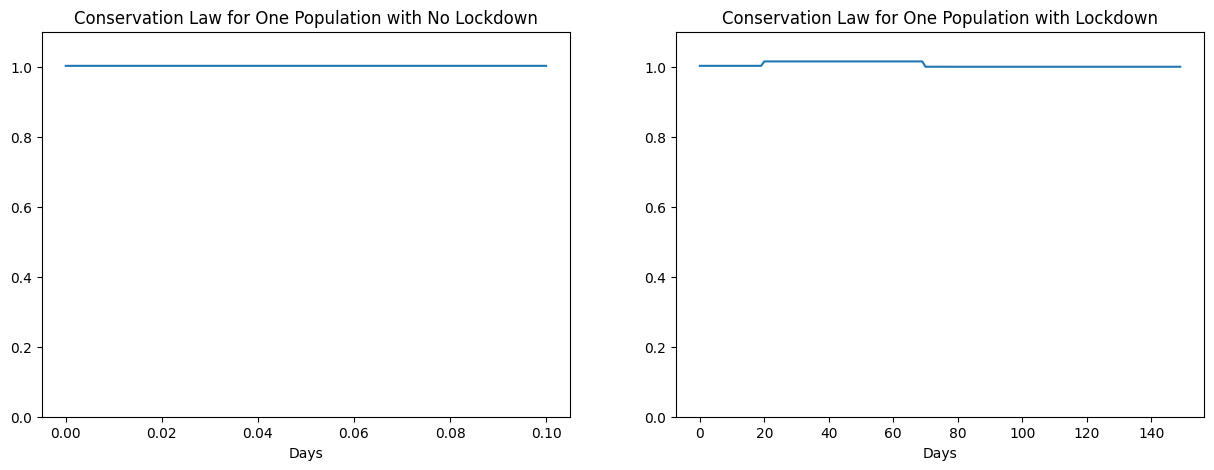

In [29]:
# Test conservation law for 1 pop
import matplotlib.pyplot as plt
import numpy as np
import math

# Implementation for one population
beta = np.array([0.2, 0, 0, 0]) # Transmittion rate
Ns = np.array([100, 0])         # Population size

sirs_object = SIR(beta, Ns)  # Create the SIR Model object

# Initialize variables
h           = 0.1                   # Timestep
x0          = np.array([1, 0])      # Initial infected percentage of population
s0          = Ns - x0               # Initial susceptible percentage of pop
r0          = np.array([0, 0])      # Initial recovered percentage of pop
gammas      = np.array([0.05, 0])   # Rate of healing
numsteps    = 150                   # Number of steps
p           = 0.2252                # Lockdown factor: affects rate of transmittion beta
tsrange     = np.array([0,0])       # Range for start times of lockdowns  
lockdownlen = np.array([0,0])       # Length of each lockdown

# Added beta, Ns, and lockdownlen for saving data, but only need inits[0:7] for calculation
inits = [h,s0,x0,r0,gammas,p,numsteps]
ss, xs, rs = sirs_object.simulate(inits,[tsrange,lockdownlen],0.1)
xaxis = np.arange(0,len(ss)*0.1,0.1)

# Simple conservation law with one population reproduction number
def conserve(S, I, beta, gamma):
    return I + S - gamma/beta * math.log(S) 

yaxis = []
for m in range(len(ss)): 
    yaxis.append(conserve(ss[m][0]/Ns[0], xs[m][0]/Ns[0], beta[0], gammas[0]))

fig, axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)
axs[0].plot(xaxis, yaxis)
axs[0].set_ylim([0,1.1])
axs[0].set_title('Conservation Law for One Population with No Lockdown')
axs[0].set_xlabel('Days')

# ----------------------------------------------------------------------------------- #
yaxis = []
ss, xs, rs = sirs_object.simulate(inits,[[20],[50]],1) # Lockdown ts = 20, lasts for 50 days
xaxis = range(len(ss))
for m in range(len(ss)): 
    if m >= 20 and m < 20 + 50: b = p * beta[0]
    else: b = beta[0]
    yaxis.append(conserve(ss[m][0]/Ns[0], xs[m][0]/Ns[0], b, gammas[0])) 
axs[1].plot(xaxis, yaxis)
#plt.plot([20,20],[0,1.1]) # ts line
axs[1].set_ylim([0,1.1])
axs[1].set_title('Conservation Law for One Population with Lockdown')
axs[1].set_xlabel('Days')

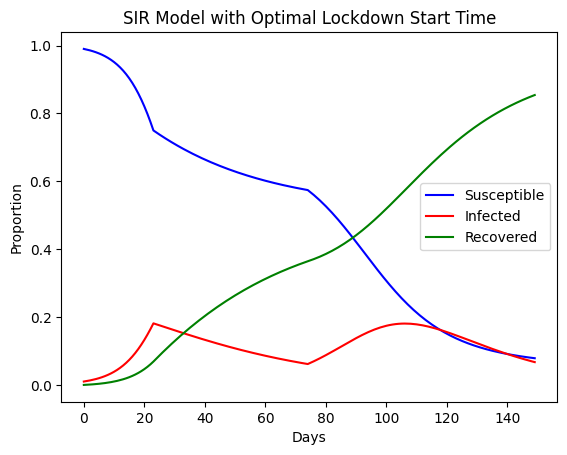

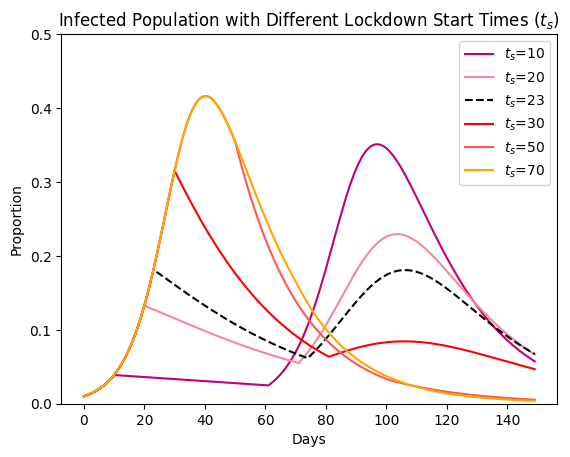

In [77]:
# Creates two timeseries plots based on the work from Sontag's paper
# Use two population code for one population
import matplotlib.pyplot as plt

# Implementation for one population
beta = np.array([0.2, 0, 0, 0]) # Transmittion rate
Ns = np.array([100, 0])         # Population size

sirs_object = SIR(beta, Ns)     # Create the SIR Model object

# Initialize variables
h = 1                           # Timestep
x0 = np.array([1, 0])           # Initial infected percentage of population
s0 = Ns - x0                    # Initial susceptible percentage of pop
r0 = np.array([0, 0])           # Initial recovered percentage of pop
gammas = np.array([0.05, 0])    # Rate of healing
numsteps = 150                  # Number of steps
p = 0.2252                      # Lockdown factor: affects rate of transmittion beta
tsrange     = np.array([0,0]) # Range for start times of lockdowns  
lockdownlen = np.array([80,0]) # Length of each lockdown

# Added beta, Ns, and lockdownlen for saving data, but only need inits[0:7] for calculation
inits = [h,s0,x0,r0,gammas,p,numsteps]#,beta,Ns,tsrange,lockdownlen]

maxes, mindex = [], 0
# Loop through different start times of lockdown
for i in range(100):
    # Start day and length of lockdown
    lockdown = [[i], [50]]
    ss, xs, rs = sirs_object.simulate(inits,lockdown,1)

    # Find the maximum peak of infections #and whether it is an equal peak
    max = np.max(xs)
    maxes.append(max)
    if max == np.min(maxes):
        min = [ss, xs, rs]
        mindex = i

# --------------------------------------------------------------------------------------- #
# Plot the three curves: susceptible is blue, infected is red, and recovered is green
fig, ax = plt.subplots()
ax.plot(range(numsteps),min[0][0:len(min[0]),0]/Ns[0],'b', label='Susceptible') # Susceptible
ax.plot(range(numsteps),min[1][0:len(min[0]),0]/Ns[0],'r', label='Infected') # Infected
ax.plot(range(numsteps),min[2][0:len(min[0]),0]/Ns[0],'g', label='Recovered') # Recovered 
# Add labels, title, and legend
ax.set_xlabel('Days')
ax.set_ylabel('Proportion')
ax.set_title('SIR Model with Optimal Lockdown Start Time')
ax.legend()
# Display the plot
plt.show()

# --------------------------------------------------------------------------------------- #
# This is from the Sontag paper
# Create a figure to show iterations of lockdown start time including the found minimum value
fig, ax = plt.subplots()
colors = ['xkcd:magenta','xkcd:rose pink','black','red','xkcd:coral','orange'] # Colors to match poster
colorcnt = 0

# Loop through different start times of lockdown
for i in [10, 20, mindex, 30, 50, 70]:
    # Start day and length of lockdown
    lockdown = [[i], [50]]
    ss, xs, rs = sirs_object.simulate(inits,lockdown,1)
    label = f'$t_s$={i}'

    if i != mindex: line='solid'
    else: line='dashed'

    # Plot each iteration of the infection curve
    ax.plot(range(numsteps),xs[0:len(xs),0]/Ns[0], label=label, linestyle=line,color=colors[colorcnt])
    colorcnt = colorcnt + 1 

# Add labels, title, limits for y-axis, and legend
ax.set_xlabel('Days')
ax.set_ylabel('Proportion')
ax.set_title('Infected Population with Different Lockdown Start Times ($t_s$)')
ax.set_ylim(0, 0.5)
ax.legend()

# Display the plot
plt.show()
